In [1]:
# Import necessary libraries
import os              # Operating system module
import shutil          # File operations module
import numpy as np     # Numerical computing library
import pandas as pd    # Data manipulation library
import matplotlib.pyplot as plt   # Plotting library
%matplotlib inline
import cv2             # OpenCV library for computer vision tasks
import glob            # File path manipulation library
import random          # Random number generation library
import tensorflow as tf   # TensorFlow machine learning framework
import keras.utils as image   # Keras utilities for image-related tasks

# Set random seeds for reproducibility
random.seed(42)
tf.random.set_seed(42)

# Import necessary components from TensorFlow and Keras
from tensorflow.keras import layers   # Keras layers for building neural networks
from tensorflow.keras.applications import VGG16   # Pre-trained VGG16 model
from tensorflow.keras.utils import to_categorical   # Utility for one-hot encoding categorical variables
from sklearn.model_selection import train_test_split   # Function for data splitting
from tensorflow.keras.preprocessing.image import ImageDataGenerator   # Image data preprocessing and augmentation
import pickle   # Python object serialization module
import keras_tuner as kt   # Keras Tuner for hyperparameter tuning
import tensorflow.keras.backend as K   # TensorFlow backend operations


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"




### The model used in this notebook is ResNet50 


### Reading the Data

In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/breast-cancer-data

# Accessing the directory containing breast histopathology images
input_directory = "histopathologic-cancer-detection"

data = os.listdir(input_directory)  # List all files in the specified directory

output_directory = "all_images_directory"  # Placeholder for the directory path to organize or process images

In [3]:
# Splitting the dataset into training and validation sets
train_data, validation_data = train_test_split(data, test_size=0.3, random_state=42)  # 70% training, 30% validation

# Further splitting the validation data into validation and test sets (50% each)
validation_data, test_data = train_test_split(validation_data, test_size=0.5, random_state=42)

# Setting up ImageDataGenerator for data preprocessing
data_generator = ImageDataGenerator(rescale=1./255)  # Rescaling pixel values to [0, 1]
target_image_size = (50, 50)  # Specifying target image size for resizing
batch_size = 32  # Setting batch size for training/validation/test data

# Creating generators for training, validation, and test sets using ImageDataGenerator
train_data_generator = data_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col="path",
    y_col="label",
    target_size=target_image_size,
    batch_size=batch_size,
    class_mode='raw'
)

validation_data_generator = data_generator.flow_from_dataframe(
    dataframe=validation_data,
    x_col="path",
    y_col="label",
    target_size=target_image_size,
    batch_size=batch_size,
    class_mode='raw'
)

test_data_generator = data_generator.flow_from_dataframe(
    dataframe=test_data,
    x_col="path",
    y_col="label",
    target_size=target_image_size,
    batch_size=batch_size,
    class_mode='raw'
)


Found 56000 validated image filenames.
Found 12000 validated image filenames.
Found 12000 validated image filenames.


In [4]:
# Compute the unique classes and their respective counts in the training generator
A, B = np.unique(train_generator.labels, return_counts=True)

# Calculate the total number of samples in the training set
n = len(train_generator.labels)

# Compute class weights to handle class imbalance
# The dictionary 'cls_weights' will contain class weights for each class
# The formula used for class weighting: weight = (total_samples - count_of_samples_in_class) / total_samples
cls_weights = {i: (n - j) / n for i, j in zip(A, B)}


In [5]:
def calculate_f1_score(true_labels, predicted_labels):
    # Calculate the number of true positives
    true_positive_count = K.sum(K.round(K.clip(true_labels * predicted_labels, 0, 1)))

    # Calculate the number of possible positives (actual positives in true_labels)
    possible_positive_count = K.sum(K.round(K.clip(true_labels, 0, 1)))

    # Calculate the number of predicted positives
    predicted_positive_count = K.sum(K.round(K.clip(predicted_labels, 0, 1)))

    # Calculate precision, recall, and F1 score with epsilon smoothing
    precision = true_positive_count / (predicted_positive_count + K.epsilon())
    recall = true_positive_count / (possible_positive_count + K.epsilon())
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1_score


### Model Optimization

In [6]:
def build_transfer_learning_model(hp):
    # Load the pre-trained ResNet50 model
    base_model = tf.keras.applications.ResNet50(
        input_shape=(50, 50, 3),
        include_top=False,
        pooling='max'
    )

    # Freeze the pre-trained model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Hyperparameter for dense layer units
    units = hp.Int("dense_units", min_value=50, max_value=100, step=10)

    # Add dense layers on top of the pre-trained model
    x = tf.keras.layers.Dense(units, activation='relu')(base_model.output)
    x = tf.keras.layers.Dense(units // 2, activation='relu')(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Create the transfer learning model
    transfer_learning_model = tf.keras.models.Model(base_model.input, output)

    # Hyperparameter for learning rate
    hp_learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    # Compile the model with chosen optimizer, loss function, and metrics
    transfer_learning_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.Recall(),
            tf.keras.metrics.Precision(),
            f1_score
        ]
    )

    return transfer_learning_model


In [7]:
# Define a Hyperband tuner for hyperparameter optimization
tuner = kt.Hyperband(
    hp_model,  # The hyperparameter model function to optimize
    objective=kt.Objective('f1_score', 'max'),  # Objective to maximize (in this case, 'f1_score')
    max_epochs=10,  # Maximum number of epochs for training
    factor=3,  # Reduction factor for the number of models and epochs
    directory='Optimizations',  # Directory to store tuning results
    project_name='resnetOptimization'  # Name of the tuning project
)


In [8]:
# Define an EarlyStopping callback to stop training when validation loss doesn't improve
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Perform hyperparameter search using the tuner
tuner.search(
    train_generator,  # Training data generator
    epochs=50,  # Number of epochs for hyperparameter search
    validation_data=val_generator,  # Validation data generator
    callbacks=[stop_early]  # Early stopping callback to prevent overfitting
)

# Get the best hyperparameters found during the search
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


### Training the Final Model

In [10]:
def train_best_transfer_learning_model(learning_rate, units):
    # Load the pre-trained ResNet50 model
    base_model = tf.keras.applications.ResNet50(
        input_shape=(50, 50, 3),
        include_top=False,
        pooling='max'
    )

    # Freeze the pre-trained model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Adding additional layers for transfer learning
    x = tf.keras.layers.Dense(units, activation='relu')(base_model.output)
    x = tf.keras.layers.Dense(units // 2, activation='relu')(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Create the transfer learning model
    transfer_learning_model = tf.keras.models.Model(base_model.input, output)

    # Compile the transfer learning model with specified optimizer, loss function, and metrics
    transfer_learning_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.Recall(),
            tf.keras.metrics.Precision(),
            f1_score
        ]
    )

    # Train the model with early stopping and class weights
    history = transfer_learning_model.fit(
        train_generator,
        epochs=300,
        validation_data=val_generator,
        callbacks=tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.001),
        class_weight=cls_weights
    )

    # Evaluate the model on the test dataset
    test_results = transfer_learning_model.evaluate(test_generator)

    return transfer_learning_model, history, test_results


In [11]:
# Results obtained from Keras Tuner with the best hyperparameters
best_params = {
    'units': 80,
    'learning_rate': 0.001 
}

# Train the transfer learning model using the best hyperparameters
best_model, history, test_results = train_best_transfer_learning_model(**best_params)


94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/300
1750/1750 [==============================] - 535s 299ms/step - loss: 0.2532 - recall: 0.6640 - precision: 0.4340 - f1_score: 0.5060 - val_loss: 0.5795 - val_recall: 0.7138 - val_precision: 0.4891 - val_f1_score: 0.5689
Epoch 2/300
1750/1750 [==============================] - 103s 59ms/step - loss: 0.2360 - recall: 0.6686 - precision: 0.5024 - f1_score: 0.5607 - val_loss: 0.7307 - val_recall: 0.9019 - val_precision: 0.3748 - val_f1_score: 0.5203
Epoch 3/300
1750/1750 [==============================] - 82s 47ms/step - loss: 0.2319 - recall: 0.6836 - precision: 0.5115 - f1_score: 0.5723 - val_loss: 0.5526 - val_recall: 0.7067 - val_precision: 0.5195 - val_f1_score: 0.5849
Epoch 4/300
1750/1750 [==============================] - 83s 47ms/step - loss: 0.2306 - recall: 0.6870 - precision: 0.5139 - f1_score: 0.5751 - val_loss: 0.5336 - val_recall: 0.6725 - val_precision: 0.5434 - val_f1_score: 0.5884
Epoch 5/300
1750

/tmp/ipykernel_23/2973932866.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


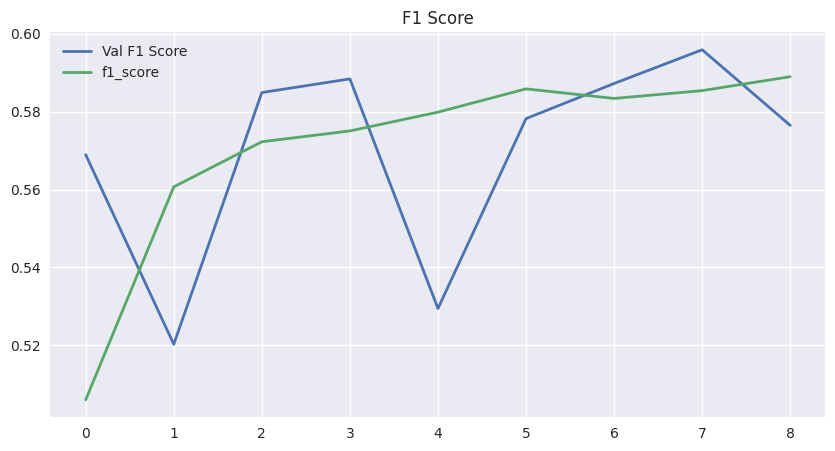

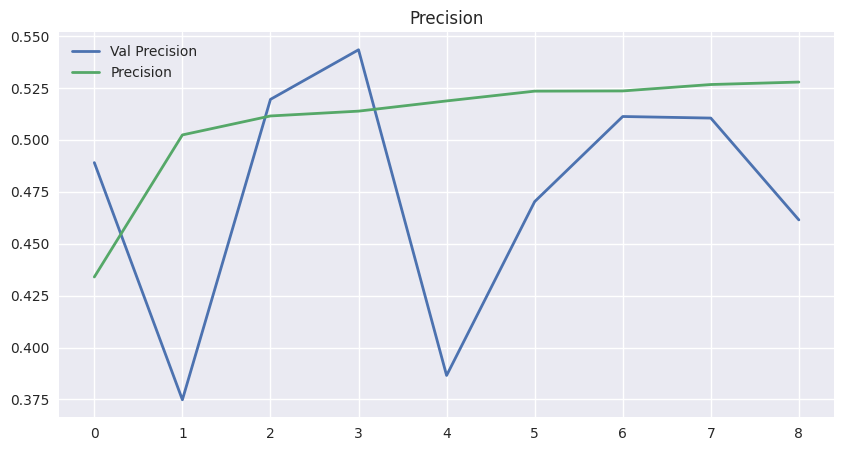

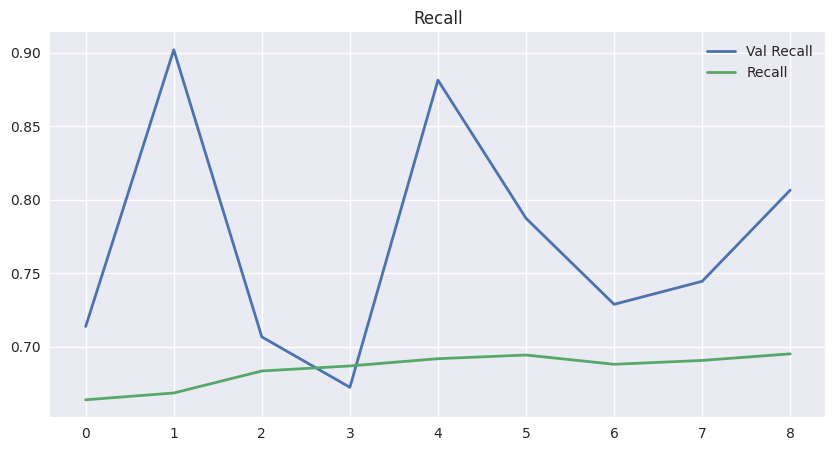

In [13]:
def plot_training_results(history):
    # Plotting F1 Score
    plt.style.use('seaborn')
    plt.figure(figsize=(10, 5))
    plt.plot(history.epoch, history.history['val_f1_score'], label='Validation F1 Score', linewidth=2)
    plt.plot(history.epoch, history.history['f1_score'], label='Training F1 Score', linewidth=2)
    plt.legend()
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.show()

    # Plotting Precision
    plt.figure(figsize=(10, 5))
    plt.plot(history.epoch, history.history['val_precision'], label='Validation Precision', linewidth=2)
    plt.plot(history.epoch, history.history['precision'], label='Training Precision', linewidth=2)
    plt.legend()
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.show()

    # Plotting Recall
    plt.figure(figsize=(10, 5))
    plt.plot(history.epoch, history.history['val_recall'], label='Validation Recall', linewidth=2)
    plt.plot(history.epoch, history.history['recall'], label='Training Recall', linewidth=2)
    plt.legend()
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.show()

# Visualize the training results using the provided 'history' object
plot_training_results(history)


In [14]:
# Displaying the test results
print("Test Results")
print("\n-------------\n")
print(f"Test Loss: {test_results[0]:.3f}")  # Print Test Loss rounded to 3 decimal places
print(f"Test Precision: {test_results[1]:.3f}")  # Print Test Precision rounded to 3 decimal places
print(f"Test Recall: {test_results[2]:.3f}")  # Print Test Recall rounded to 3 decimal places
print(f"Test F1: {test_results[3]:.3f}")  # Print Test F1 Score rounded to 3 decimal places


Test Results

-------------

Test Loss: 0.637
Test Precision:  0.805
Test Recall:  0.452
Test F1: 0.569


<a id='4'></a>
## 4. Calculating the Number of Parameters and Amount of Mult Adds Needed

In [15]:
total_parameters = model.count_params()  # Calculate the total number of parameters in the model
mult_adds_total = 0  # Initialize the counter for total multiply-accumulate operations

# Iterate through each layer in the model
for layer in model.layers:
    # Check if the layer is a Conv2D layer
    if isinstance(layer, tf.keras.layers.Conv2D):
        # Extract input shape details (height, width, and channels)
        height, width, channels_in = layer.input_shape[1:]
        # Extract output shape details (height, width, and channels)
        _, _, channels_out = layer.output_shape[1:]
        # Extract kernel size (height and width)
        kernel_height, kernel_width = layer.kernel_size
        
        # Calculate the number of multiply-accumulate operations for the Conv2D layer
        mult_adds = height * width * channels_in * channels_out * kernel_height * kernel_width
        # Accumulate the total number of multiply-accumulate operations
        mult_adds_total += mult_adds

# Display the calculated values
print("Total parameters:", total_parameters)  # Print the total number of parameters in the model
print("Total number of multiply-accumulates:", mult_adds_total) 


Total parameters: 23754913
Total number of multipy-accumulates: 370667520


In [ ]:
model.save('modelResNet.h5')